# Production Considerations and Changes

* Label maturity check/analysis: before training I confirm defaults are “final” (due date + buffer), so I’m not learning from incomplete labels.
* No leakage mindset: features should be “as-of origination” only, and threshold/calibration is decided using VAL (never peeking at TEST).
* Config over hard-coding: windows (30/90/180), params, threshold policy, calibration method all live in YAML so changes are controlled + reproducible.
* Logging over prints: use logging to write clean logs to files (levels: info/warn/error) instead of messy print() everywhere.
* Packaging + versioning: keep code as a small package + pinned dependencies; save model + feature list + config + git hash as one artifact.
* Docker / environment match: run training + inference in Docker so local/staging/prod behave the same (no “works on my laptop” issues).
* System design clarity (real-time vs batch): decide early if this is real-time scoring (low latency) or batch inference (nightly/hourly), because feature availability and infra are different.
* Latency + SLA driven choices: for real-time, I design for SLA (p95 latency, throughput), and keep features lightweight + cached; for batch, I optimize for cost + runtime window.
* Capacity constraints: confirm client limits (CPU/GPU, memory, concurrency, cost) and pick model complexity + embedding strategy that fits (offline embeddings if online is too heavy).
* Deployment + monitoring: ship with basic monitoring for data drift + score drift + calibration drift, and set alerts when things move outside expected range.

# Libraries

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)
from lightgbm import LGBMClassifier
from sklearn.model_selection import GroupShuffleSplit, TimeSeriesSplit

import shap
# !pip -q install tree-influence
# from tree_influence.explainers import BoostIn
# import lime
# import mlflow
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.feature_selection import mutual_info_classif # dependency of features
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    brier_score_loss
)

pd.set_option('display.max_columns', None)

# Loan DF

In [ ]:
# read the files
loan_df = pd.read_csv('/content/oscilar_loan_df.csv')
print(loan_df.shape)
display(loan_df.head())


(22838, 7)


,loan_id,customer_id,loan_amount,created_at,due_at,repaid_at,fico_score
0,20369e4b-49ba-476e-b08c-01acdc3ee49b,3294395121,50.0,2024-01-15T18:15:47.023421Z,2024-02-01T16:00:00Z,2024-02-01T16:24:42.472336Z,767
1,a2eb6f15-6235-4585-ad32-bc462a6b3d4c,3294395121,50.0,2024-01-02T00:10:53.621997Z,2024-01-15T16:00:00Z,2024-01-15T16:48:02.06984Z,692
2,8cee431a-791a-402c-8e6b-f7f822b5dc3a,3295846714,30.0,2024-01-02T14:50:00.159604Z,2024-01-15T16:00:00Z,2024-01-19T08:04:07.035901Z,712
3,7b802a24-e7fb-4677-be92-5f08b436cd45,3295846714,58.0,2024-01-27T17:12:08.391725Z,2024-02-02T16:00:00Z,2024-02-02T16:17:50.941277Z,722
4,8b9df486-d85a-4380-95bb-2eeb3ddb4b0d,3295844478,30.0,2024-01-04T16:05:40.710036Z,2024-01-15T16:00:00Z,2024-01-19T08:27:44.969304Z,707


## Cleaning

In [ ]:
print("Data types:\n", loan_df.dtypes)
print("Missing values:\n", loan_df.isnull().sum())
print("Numeric summary:\n", loan_df.describe())
print("Unique customers:", loan_df.customer_id.nunique())

Data types:
 loan_id         object
customer_id      int64
loan_amount    float64
created_at      object
due_at          object
repaid_at       object
fico_score       int64
dtype: object
Missing values:
 loan_id           0
customer_id       0
loan_amount       0
created_at        0
due_at            0
repaid_at      4783
fico_score        0
dtype: int64
Numeric summary:
         customer_id   loan_amount    fico_score
count  2.283800e+04  22838.000000  22838.000000
mean   3.253284e+09     48.834880    696.923373
std    1.319620e+08     37.299949     31.160795
min    2.824769e+09      5.000000    662.000000
25%    3.291739e+09     30.000000    672.000000
50%    3.294803e+09     30.000000    692.000000
75%    3.296916e+09     50.000000    712.000000
max    3.297664e+09    250.000000    847.000000
Unique customers: 16482


In [ ]:
loan_df['created_at'] = pd.to_datetime(loan_df['created_at'], format='ISO8601')
loan_df['due_at'] = pd.to_datetime(loan_df['due_at'], format='ISO8601')
loan_df['repaid_at'] = pd.to_datetime(loan_df['repaid_at'], format='ISO8601')
print(loan_df.dtypes)

loan_id                     object
customer_id                  int64
loan_amount                float64
created_at     datetime64[ns, UTC]
due_at         datetime64[ns, UTC]
repaid_at      datetime64[ns, UTC]
fico_score                   int64
dtype: object


## Label Creation

In [ ]:
# Label creation - if repaid_at is null then DEFAULT
loan_df['is_default'] = loan_df['repaid_at'].isnull().astype(int)
loan_df.head()

,loan_id,customer_id,loan_amount,created_at,due_at,repaid_at,fico_score,is_default
0,20369e4b-49ba-476e-b08c-01acdc3ee49b,3294395121,50.0,2024-01-15 18:15:47.023421+00:00,2024-02-01 16:00:00+00:00,2024-02-01 16:24:42.472336+00:00,767,0
1,a2eb6f15-6235-4585-ad32-bc462a6b3d4c,3294395121,50.0,2024-01-02 00:10:53.621997+00:00,2024-01-15 16:00:00+00:00,2024-01-15 16:48:02.069840+00:00,692,0
2,8cee431a-791a-402c-8e6b-f7f822b5dc3a,3295846714,30.0,2024-01-02 14:50:00.159604+00:00,2024-01-15 16:00:00+00:00,2024-01-19 08:04:07.035901+00:00,712,0
3,7b802a24-e7fb-4677-be92-5f08b436cd45,3295846714,58.0,2024-01-27 17:12:08.391725+00:00,2024-02-02 16:00:00+00:00,2024-02-02 16:17:50.941277+00:00,722,0
4,8b9df486-d85a-4380-95bb-2eeb3ddb4b0d,3295844478,30.0,2024-01-04 16:05:40.710036+00:00,2024-01-15 16:00:00+00:00,2024-01-19 08:27:44.969304+00:00,707,0


In [ ]:
print("Default label counts:")
print(loan_df['is_default'].value_counts())

print("\nDefault label distribution (%):")
print((loan_df['is_default'].value_counts(normalize=True) * 100).round(2))


Default label counts:
is_default
0    18055
1     4783
Name: count, dtype: int64

Default label distribution (%):
is_default
0    79.06
1    20.94
Name: proportion, dtype: float64


# Trxn DF

In [ ]:
trxn_df = pd.read_csv('/content/oscilar_txn_df.csv')
print(trxn_df.shape)
display(trxn_df.head())

(3944578, 5)


,loan_id,customer_id,category,amount,posted_date
0,a5448199-1ab5-44ff-b8f7-24839447dcbb,3297622675,Gas & Fuel,-20.00,2024-01-30T12:00:00Z
1,a5448199-1ab5-44ff-b8f7-24839447dcbb,3297622675,Food & Dining,-1.60,2024-01-30T12:00:00Z
2,a5448199-1ab5-44ff-b8f7-24839447dcbb,3297622675,Gas & Fuel,-22.22,2024-01-29T12:00:00Z
3,a5448199-1ab5-44ff-b8f7-24839447dcbb,3297622675,Cash & ATM,-500.00,2024-01-29T12:00:00Z
4,a5448199-1ab5-44ff-b8f7-24839447dcbb,3297622675,Fast Food,-20.73,2024-01-29T12:00:00Z


## Cleaning

In [ ]:
print("Trxn DF Shape:", trxn_df.shape)
print("\nUnique Values:\n",  trxn_df.nunique())
print("\nData types:\n", trxn_df.dtypes)
print("\nMissing values:\n", trxn_df.isnull().sum())
print("\nNumeric summary:\n", trxn_df.describe())
print("\nUnique customers:", trxn_df.customer_id.nunique())


Trxn DF Shape: (3944578, 5)

Unique Values:
 loan_id          4532
customer_id      4236
category          117
amount         116571
posted_date    208034
dtype: int64

Data types:
 loan_id         object
customer_id      int64
category        object
amount         float64
posted_date     object
dtype: object

Missing values:
 loan_id            0
customer_id        0
category           3
amount         44421
posted_date        3
dtype: int64

Numeric summary:
         customer_id        amount
count  3.944578e+06  3.900157e+06
mean   3.247314e+09  2.008212e-01
std    1.394476e+08  3.109186e+02
min    2.825516e+09 -5.870575e+04
25%    3.291260e+09 -3.400000e+01
50%    3.294181e+09 -1.089000e+01
75%    3.296719e+09 -8.200000e-01
max    3.297664e+09  1.439841e+05

Unique customers: 4236


In [ ]:
trxn_df['posted_date'] = pd.to_datetime(trxn_df['posted_date'], format='ISO8601') # convert to correct datetime dtype
trxn_df['amount_abs'] = trxn_df['amount'].abs()
# since amount captures bi-directional behaviours, both credit and debits - ABS helps us capture magnitude irrespective of direction

# differentiating credits vs debits
trxn_df['is_debit'] = (trxn_df['amount'] < 0).astype(int)
trxn_df['is_credit'] = (trxn_df['amount'] > 0).astype(int)

print("posted_date min:", trxn_df['posted_date'].min()); print("posted_date max:", trxn_df['posted_date'].max())

print(trxn_df.shape)
trxn_df.head()

posted_date min: 2023-07-01 07:00:00+00:00
posted_date max: 2024-01-31 23:22:22+00:00
(3944578, 8)


,loan_id,customer_id,category,amount,posted_date,amount_abs,is_debit,is_credit
0,a5448199-1ab5-44ff-b8f7-24839447dcbb,3297622675,Gas & Fuel,-20.00,2024-01-30 12:00:00+00:00,20.00,1,0
1,a5448199-1ab5-44ff-b8f7-24839447dcbb,3297622675,Food & Dining,-1.60,2024-01-30 12:00:00+00:00,1.60,1,0
2,a5448199-1ab5-44ff-b8f7-24839447dcbb,3297622675,Gas & Fuel,-22.22,2024-01-29 12:00:00+00:00,22.22,1,0
3,a5448199-1ab5-44ff-b8f7-24839447dcbb,3297622675,Cash & ATM,-500.00,2024-01-29 12:00:00+00:00,500.00,1,0
4,a5448199-1ab5-44ff-b8f7-24839447dcbb,3297622675,Fast Food,-20.73,2024-01-29 12:00:00+00:00,20.73,1,0


## Merging DF's

* General Assumption - Prediction is to be made at Loan Creation/Origination Time



In [ ]:
print("Unique loans in loan_df:", loan_df['loan_id'].nunique())
print("Unique loans in trxn_df:", trxn_df['loan_id'].nunique())
print("Loans present in both:", loan_df['loan_id'].isin(trxn_df['loan_id']).sum())
print("Loans missing txn rows:", (~loan_df['loan_id'].isin(trxn_df['loan_id'])).sum())


Unique loans in loan_df: 22838
Unique loans in trxn_df: 4532
Loans present in both: 4532
Loans missing txn rows: 18306


In [ ]:
# Attach created_at so we can build "as-of origination" features
txn_with_created = trxn_df.merge(
    loan_df[['loan_id', 'created_at']],
    on='loan_id',
    how='inner'
)

# Ensuring 'created_at' is datetime type after merge
txn_with_created['created_at'] = pd.to_datetime(txn_with_created['created_at'], errors='coerce')

print("posted_date min:", txn_with_created['posted_date'].min())
print("posted_date max:", txn_with_created['posted_date'].max())

# lookback_days = 180
# start_window = txn_with_created['created_at'] - pd.Timedelta(days=lookback_days)

# txn_hist = txn_with_created[
#     (txn_with_created['posted_date'] <= txn_with_created['created_at']) &
#     (txn_with_created['posted_date'] >= start_window)
# ].copy()

posted_date min: 2023-07-01 07:00:00+00:00
posted_date max: 2024-01-31 23:22:22+00:00


# Feature Engineering
* I chose tree-based models for this problem, so I intentionally skipped feature scaling and log transformations.
* Tree models are invariant to monotonic transformations and do not rely on distance-based calculations, which makes scaling largely unnecessary.
* In practice, I found that log transforms added little incremental value while reducing interpretability of the features.
* I therefore kept the features in their original scale to keep the pipeline simpler and easier to reason about.
* I handled the categorcal variables a bit differently and hence, didn't really needed to use One-Hot Encoding or CatBoostEncoding (Ordered Statistic Target Encoding)

In [ ]:
# I computed the same small set of transaction features over multiple recency windows
# so the model can distinguish short-term risk from longer-term behavior without overfitting.

# Transaction features for multiple lookback windows (30 / 90 / 180 days)
# Use a flexible lookback window prior to origination (e.g., last 60/90/120 days or whole history)
# Recency matters --> Recent behavior (last 30–180 days) is usually more predictive than what happened a long time ago.
# Whole-history aggregates can possibly dilute signal.
windows = [30, 90, 180]
txn_agg_list = []

for w in windows:
    # Keep transactions in the last w days, up to the loan's created_at
    start_window = txn_with_created['created_at'] - pd.Timedelta(days=w)
    txn_hist = txn_with_created[
        (txn_with_created['posted_date'] <= txn_with_created['created_at']) &
        (txn_with_created['posted_date'] >= start_window)
    ].copy()

    # Roll up to one row per loan_id
    agg = (
        txn_hist
        .groupby('loan_id')
        .agg(
            txn_count=('amount', 'count'),
            debit_txn_count=('is_debit', 'sum'),
            credit_txn_count=('is_credit', 'sum'),
            total_amount_abs=('amount_abs', 'sum'),
            avg_amount_abs=('amount_abs', 'mean'),
            max_amount_abs=('amount_abs', 'max'),
            unique_categories=('category', 'nunique'),
            days_with_activity=('posted_date', lambda s: s.dt.date.nunique())
        )
        .add_suffix(f'_last_{w}d')
        .reset_index()
    )

    txn_agg_list.append(agg)

# Combine windowed feature tables (outer keeps loans that appear in some windows but not others)
txn_agg_all = txn_agg_list[0]
for agg in txn_agg_list[1:]:
    txn_agg_all = txn_agg_all.merge(agg, on='loan_id', how='outer')

# Merge transaction features back to the loan table (keep all loans)
final_df = loan_df.merge(txn_agg_all, on='loan_id', how='left')

# Fill missing txn features with zeros (means "no txn history in this window / not available")
txn_cols = [c for c in final_df.columns if c.endswith(('last_30d', 'last_90d', 'last_180d'))]
final_df[txn_cols] = final_df[txn_cols].fillna(0)

# Simple availability flags per window (helps model handle partial coverage cleanly)
for w in windows:
    final_df[f'has_txn_data_last_{w}d'] = (final_df[f'txn_count_last_{w}d'] > 0).astype(int)

print("final_df shape:", final_df.shape)
final_df.head()



final_df shape: (22838, 35)


,loan_id,customer_id,loan_amount,created_at,due_at,repaid_at,fico_score,is_default,txn_count_last_30d,debit_txn_count_last_30d,credit_txn_count_last_30d,total_amount_abs_last_30d,avg_amount_abs_last_30d,max_amount_abs_last_30d,unique_categories_last_30d,days_with_activity_last_30d,txn_count_last_90d,debit_txn_count_last_90d,credit_txn_count_last_90d,total_amount_abs_last_90d,avg_amount_abs_last_90d,max_amount_abs_last_90d,unique_categories_last_90d,days_with_activity_last_90d,txn_count_last_180d,debit_txn_count_last_180d,credit_txn_count_last_180d,total_amount_abs_last_180d,avg_amount_abs_last_180d,max_amount_abs_last_180d,unique_categories_last_180d,days_with_activity_last_180d,has_txn_data_last_30d,has_txn_data_last_90d,has_txn_data_last_180d
0,20369e4b-49ba-476e-b08c-01acdc3ee49b,3294395121,50.0,2024-01-15 18:15:47.023421+00:00,2024-02-01 16:00:00+00:00,2024-02-01 16:24:42.472336+00:00,767,0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0,0
1,a2eb6f15-6235-4585-ad32-bc462a6b3d4c,3294395121,50.0,2024-01-02 00:10:53.621997+00:00,2024-01-15 16:00:00+00:00,2024-01-15 16:48:02.069840+00:00,692,0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0,0
2,8cee431a-791a-402c-8e6b-f7f822b5dc3a,3295846714,30.0,2024-01-02 14:50:00.159604+00:00,2024-01-15 16:00:00+00:00,2024-01-19 08:04:07.035901+00:00,712,0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0,0
3,7b802a24-e7fb-4677-be92-5f08b436cd45,3295846714,58.0,2024-01-27 17:12:08.391725+00:00,2024-02-02 16:00:00+00:00,2024-02-02 16:17:50.941277+00:00,722,0,136.0,109.0,27.0,10392.17,76.413015,969.3,23.0,18.0,395.0,316.0,79.0,30810.69,78.001747,1500.0,33.0,58.0,710.0,584.0,126.0,58957.6,83.038873,1500.0,38.0,116.0,1,1,1
4,8b9df486-d85a-4380-95bb-2eeb3ddb4b0d,3295844478,30.0,2024-01-04 16:05:40.710036+00:00,2024-01-15 16:00:00+00:00,2024-01-19 08:27:44.969304+00:00,707,0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0,0


In [ ]:
# Length of the loan in days.
# Shorter-term loans often behave differently from longer ones.
final_df['loan_term_days'] = (final_df['due_at'] - final_df['created_at']).dt.days

# Average number of transactions per active day in the last 30 days.
# Helps distinguish steady activity from short bursts of heavy usage.
final_df['txn_per_active_day_30d'] = (
    final_df['txn_count_last_30d'] /
    final_df['days_with_activity_last_30d'].replace(0, np.nan)
).fillna(0)

# Ratio of the largest transaction to the average transaction size (90d).
# Captures how spiky or volatile recent spending is.
final_df['max_to_avg_ratio_90d'] = (
    final_df['max_amount_abs_last_90d'] /
    final_df['avg_amount_abs_last_90d'].replace(0, np.nan)
).fillna(0)

# Share of transactions that are debits over the last 90 days.
# Higher values suggest more cash outflow relative to inflow.
final_df['debit_share_90d'] = (
    final_df['debit_txn_count_last_90d'] /
    final_df['txn_count_last_90d'].replace(0, np.nan)
).fillna(0)

# Number of unique spending categories normalized by activity (90d).
# Indicates whether spending is concentrated or spread across categories.
final_df['category_diversity_90d'] = (
    final_df['unique_categories_last_90d'] /
    final_df['txn_count_last_90d'].replace(0, np.nan)
).fillna(0)

# Recent transaction activity relative to longer-term history.
# Highlights sudden increases in activity close to origination.
final_df['txn_acceleration'] = (
    final_df['txn_count_last_30d'] /
    final_df['txn_count_last_180d'].replace(0, np.nan)
).fillna(0)

# Loan amount compared to typical transaction size (90d).
# Flags loans that are large relative to the customer’s usual behavior.
final_df['loan_to_avg_txn_90d'] = (
    final_df['loan_amount'] /
    final_df['avg_amount_abs_last_90d'].replace(0, np.nan)
).fillna(0)

final_df.head()


,loan_id,customer_id,loan_amount,created_at,due_at,repaid_at,fico_score,is_default,txn_count_last_30d,debit_txn_count_last_30d,credit_txn_count_last_30d,total_amount_abs_last_30d,avg_amount_abs_last_30d,max_amount_abs_last_30d,unique_categories_last_30d,days_with_activity_last_30d,txn_count_last_90d,debit_txn_count_last_90d,credit_txn_count_last_90d,total_amount_abs_last_90d,avg_amount_abs_last_90d,max_amount_abs_last_90d,unique_categories_last_90d,days_with_activity_last_90d,txn_count_last_180d,debit_txn_count_last_180d,credit_txn_count_last_180d,total_amount_abs_last_180d,avg_amount_abs_last_180d,max_amount_abs_last_180d,unique_categories_last_180d,days_with_activity_last_180d,has_txn_data_last_30d,has_txn_data_last_90d,has_txn_data_last_180d,loan_term_days,txn_per_active_day_30d,max_to_avg_ratio_90d,debit_share_90d,category_diversity_90d,txn_acceleration,loan_to_avg_txn_90d
0,20369e4b-49ba-476e-b08c-01acdc3ee49b,3294395121,50.0,2024-01-15 18:15:47.023421+00:00,2024-02-01 16:00:00+00:00,2024-02-01 16:24:42.472336+00:00,767,0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0,0,16,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1,a2eb6f15-6235-4585-ad32-bc462a6b3d4c,3294395121,50.0,2024-01-02 00:10:53.621997+00:00,2024-01-15 16:00:00+00:00,2024-01-15 16:48:02.069840+00:00,692,0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0,0,13,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2,8cee431a-791a-402c-8e6b-f7f822b5dc3a,3295846714,30.0,2024-01-02 14:50:00.159604+00:00,2024-01-15 16:00:00+00:00,2024-01-19 08:04:07.035901+00:00,712,0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0,0,13,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,7b802a24-e7fb-4677-be92-5f08b436cd45,3295846714,58.0,2024-01-27 17:12:08.391725+00:00,2024-02-02 16:00:00+00:00,2024-02-02 16:17:50.941277+00:00,722,0,136.0,109.0,27.0,10392.17,76.413015,969.3,23.0,18.0,395.0,316.0,79.0,30810.69,78.001747,1500.0,33.0,58.0,710.0,584.0,126.0,58957.6,83.038873,1500.0,38.0,116.0,1,1,1,5,7.555556,19.230339,0.8,0.083544,0.191549,0.743573
4,8b9df486-d85a-4380-95bb-2eeb3ddb4b0d,3295844478,30.0,2024-01-04 16:05:40.710036+00:00,2024-01-15 16:00:00+00:00,2024-01-19 08:27:44.969304+00:00,707,0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0,0,10,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


# Sanity Checks

In [ ]:
print("Default rate (%):", final_df['is_default'].mean() * 100)

print("\nDefaults by txn availability:")
print(
    final_df
    .groupby('has_txn_data_last_180d')['is_default']
    .mean()
)
# this tells us, deafault rate is not heavliy linked transaction data avaialbilty  - so we know model won't be biased by learning coverage

Default rate (%): 20.943164900604256

Defaults by txn availability:
has_txn_data_last_180d
0    0.210595
1    0.204726
Name: is_default, dtype: float64


# Split Strategy

* I initially explored a hybrid split combining **customer-level separation** with a **time-based split and a label-maturity buffer to avoid leakage**.
* However, due to the short time span of the data and the required buffer for outcome availability, this approach resulted in an empty test set.
* To keep the evaluation statistically meaningful while still preventing customer leakage, I used a customer-level split for model training and validation.
* I retained time-based analysis as a secondary sanity check rather than the primary evaluation strategy.

In [ ]:
# @title Trials - Time Based + Label Split
# import numpy as np
# import pandas as pd

# # -----------------------------
# # Hybrid split: time + label maturity buffer + customer separation
# # -----------------------------

# df = final_df.copy()

# # max or latest date available in dataset
# max_created = df["created_at"].max()

# # Example: last 7 days = test, previous 7 days = validation
# test_window_days = 7
# val_window_days = 7

# test_start = max_created - pd.Timedelta(days=test_window_days)
# val_start  = test_start  - pd.Timedelta(days=val_window_days)

# # This is imprtant --> Label maturity buffer:
# # We only keep loans whose due_at is at least 'buffer_days' before max_created,
# # so we’re not calling something "non-default" just because it hasn’t had time yet.
# buffer_days = 3
# label_cutoff = max_created - pd.Timedelta(days=buffer_days)

# df = df[df["due_at"] <= label_cutoff].copy()

# # Customer separation:
# # We assign each customer to a split using their earliest loan date.
# # This ensures a customer cannot appear in both train and val/test.
# cust_first = (
#     df.groupby("customer_id")["created_at"]
#       .min()
#       .rename("customer_first_created_at")
#       .reset_index()
# )

# df = df.merge(cust_first, on="customer_id", how="left")

# # Map customers into splits using their earliest observed loan date
# df["split"] = np.where(
#     df["customer_first_created_at"] >= test_start, "test",
#     np.where(df["customer_first_created_at"] >= val_start, "val", "train")
# )

# train_df = df[df["split"] == "train"].copy()
# val_df   = df[df["split"] == "val"].copy()
# test_df  = df[df["split"] == "test"].copy()

# print("Hybrid split sizes (rows):")
# print("Train:", train_df.shape)
# print("Val  :", val_df.shape)
# print("Test :", test_df.shape)

# # Quick checks: customer overlap should be zero
# train_cust = set(train_df["customer_id"])
# val_cust   = set(val_df["customer_id"])
# test_cust  = set(test_df["customer_id"])

# print("\nCustomer overlap checks (should all be 0):")
# print("Train ∩ Val :", len(train_cust & val_cust))
# print("Train ∩ Test:", len(train_cust & test_cust))
# print("Val ∩ Test  :", len(val_cust & test_cust))

# # Default rate sanity check
# print("\nDefault rate by split (%):")
# print("Train:", train_df["is_default"].mean() * 100)
# print("Val  :", val_df["is_default"].mean() * 100)
# print("Test :", test_df["is_default"].mean() * 100)


## Splits

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, classification_report
from lightgbm import LGBMClassifier

# -------------------- Target
target_col = "is_default"

# -------------------- Core loan-level features
base_loan_features = ["loan_amount", "fico_score", "loan_term_days"]

# -------------------- Transaction features (last 30 days)
txn_30d_features = [
    "txn_count_last_30d", "debit_txn_count_last_30d", "credit_txn_count_last_30d",
    "total_amount_abs_last_30d", "avg_amount_abs_last_30d", "max_amount_abs_last_30d",
    "unique_categories_last_30d", "days_with_activity_last_30d", "has_txn_data_last_30d"
]

# -------------------- Transaction features (last 90 days)
txn_90d_features = [
    "txn_count_last_90d", "debit_txn_count_last_90d", "credit_txn_count_last_90d",
    "total_amount_abs_last_90d", "avg_amount_abs_last_90d", "max_amount_abs_last_90d",
    "unique_categories_last_90d", "days_with_activity_last_90d", "has_txn_data_last_90d"
]

# -------------------- Transaction features (last 180 days)
txn_180d_features = [
    "txn_count_last_180d", "debit_txn_count_last_180d", "credit_txn_count_last_180d",
    "total_amount_abs_last_180d", "avg_amount_abs_last_180d", "max_amount_abs_last_180d",
    "unique_categories_last_180d", "days_with_activity_last_180d", "has_txn_data_last_180d"
]

# -------------------- Derived behavior features
derived_features = [
    "txn_per_active_day_30d", "max_to_avg_ratio_90d", "debit_share_90d",
    "category_diversity_90d", "txn_acceleration", "loan_to_avg_txn_90d"
]

# Final feature list used by the model
feature_cols = (
    base_loan_features +
    txn_30d_features +
    txn_90d_features +
    txn_180d_features +
    derived_features
)

# -------------------- Modeling table
df_model = final_df.copy()

X = df_model[feature_cols].copy()
y = df_model[target_col].astype(int).copy()
groups = df_model["customer_id"].copy()  # used to avoid customer leakage

print("Rows:", len(df_model))
print("Num features:", X.shape[1])
print("Overall default rate (%):", y.mean() * 100)

# -------------------- Split 1: Hold out TEST customers (never touched during tuning)
gss1 = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
trainval_idx, test_idx = next(gss1.split(X, y, groups=groups))

X_trainval, X_test = X.iloc[trainval_idx], X.iloc[test_idx]
y_trainval, y_test = y.iloc[trainval_idx], y.iloc[test_idx]
groups_trainval = groups.iloc[trainval_idx]

# -------------------- Split 2: Split remaining customers into TRAIN and VAL
# 25% of trainval = 20% of total → overall split ≈ 60 / 20 / 20
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
train_idx, val_idx = next(gss2.split(X_trainval, y_trainval, groups=groups_trainval))

X_train, X_val = X_trainval.iloc[train_idx], X_trainval.iloc[val_idx]
y_train, y_val = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]

# -------------------- Sanity checks: customer leakage
train_customers = set(groups_trainval.iloc[train_idx])
val_customers = set(groups_trainval.iloc[val_idx])
test_customers = set(groups.iloc[test_idx])

print("\nSplit sizes:")
print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

print("\nCustomer overlap checks (should be 0):")
print("Train ∩ Val :", len(train_customers & val_customers))
print("Train ∩ Test:", len(train_customers & test_customers))
print("Val ∩ Test  :", len(val_customers & test_customers))

print("\nDefault rate by split (%):")
print("Train:", y_train.mean() * 100)
print("Val  :", y_val.mean() * 100)
print("Test :", y_test.mean() * 100)


Rows: 22838
Num features: 36
Overall default rate (%): 20.943164900604256

Split sizes:
Train: (13677, 36) Val: (4536, 36) Test: (4625, 36)

Customer overlap checks (should be 0):
Train ∩ Val : 0
Train ∩ Test: 0
Val ∩ Test  : 0

Default rate by split (%):
Train: 20.58199897638371
Val  : 21.472663139329807
Test : 21.491891891891893


# Light GBM Model

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    make_scorer, average_precision_score, roc_auc_score,
    confusion_matrix, classification_report, precision_recall_curve
)
from lightgbm import LGBMClassifier

# Class imbalance helper: roughly (#non-default / #default)
scale_pos_weight = (y_train == 0).sum() / max((y_train == 1).sum(), 1)

base_model = LGBMClassifier(
    objective="binary",
    # scale_pos_weight=scale_pos_weight, # can't use both with is_unbalance as it double penalizes
    is_unbalance=True,
    random_state=42,
    n_jobs=-1
)

# Small search space so it runs quickly but still explores meaningful knobs
param_dist = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.05, 0.1],
    "num_leaves": [31, 63],
    "min_child_samples": [50, 100, 200],
    "subsample": [0.8, 1.0],
    # "colsample_bytree": [0.8, 1.0],
    "reg_lambda": [0.0, 1.0, 3.0],
    # "reg_alpha": [0.0]
}

# PR-AUC is usually more meaningful than accuracy for imbalanced default prediction
pr_auc_scorer = make_scorer(average_precision_score, needs_proba=True)

# Treat Train as the training fold and Val as the validation fold (fast single-split tuning)
X_tune = pd.concat([X_train, X_val], axis=0).reset_index(drop=True)
y_tune = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)

train_indices = np.arange(len(X_train))
val_indices = np.arange(len(X_train), len(X_train) + len(X_val))
single_split = [(train_indices, val_indices)]

search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=10,
    scoring=pr_auc_scorer,
    cv=single_split,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search.fit(X_tune, y_tune)

best_model = search.best_estimator_
print("\nBest PR-AUC on val:", search.best_score_)
print("Best params:", search.best_params_)

# Pick a threshold based on VAL only (so we don't peek at test)
val_proba = best_model.predict_proba(X_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, val_proba)

# Standard "best tradeoff" choice: maximize F1 on the validation set
f1 = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-12)
best_idx = int(np.argmax(f1))
best_threshold = float(thresholds[best_idx])

print("\nChosen threshold (max F1 on val):", best_threshold)
print("Val precision:", float(precision[best_idx]), " Val recall:", float(recall[best_idx]))

def print_split_report(name, X_split, y_split, threshold):
    proba = best_model.predict_proba(X_split)[:, 1]
    pred = (proba >= threshold).astype(int)

    print(f"\n{name} @ threshold={threshold:.4f}")
    print("ROC AUC :", roc_auc_score(y_split, proba))
    print("PR  AUC :", average_precision_score(y_split, proba))
    print("Confusion matrix:")
    print(confusion_matrix(y_split, pred))
    print("Classification report:")
    print(classification_report(y_split, pred, digits=3))

print_split_report("TRAIN", X_train, y_train, best_threshold)
print_split_report("VAL", X_val, y_val, best_threshold)
print_split_report("TEST", X_test, y_test, best_threshold)


Fitting 1 folds for each of 10 candidates, totalling 10 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


[LightGBM] [Info] Number of positive: 3789, number of negative: 14424
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6638
[LightGBM] [Info] Number of data points in the train set: 18213, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.208038 -> initscore=-1.336791
[LightGBM] [Info] Start training from score -1.336791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

# Explainability

* Key drivers are loan fundamentals (loan_amount, loan_term_days, FICO) and behavioral signals (txn acceleration, debit share, recent spend intensity).
* With more resources, we can apply Tree SHAP (BoostIn Influence Model) and tree proximity matirx based on leaf node sharing approach to identify row-level + feature-interaction drivers behind individual test predictions.


Top 15 features by importance (gain):


,feature,importance
0,loan_amount,9979.752029
2,loan_term_days,4361.590114
1,fico_score,3750.336297
34,txn_acceleration,1099.257854
32,debit_share_90d,868.206763
24,total_amount_abs_last_180d,840.231476
28,days_with_activity_last_180d,550.606527
6,total_amount_abs_last_30d,499.084111
31,max_to_avg_ratio_90d,473.375219
4,debit_txn_count_last_30d,464.971232


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


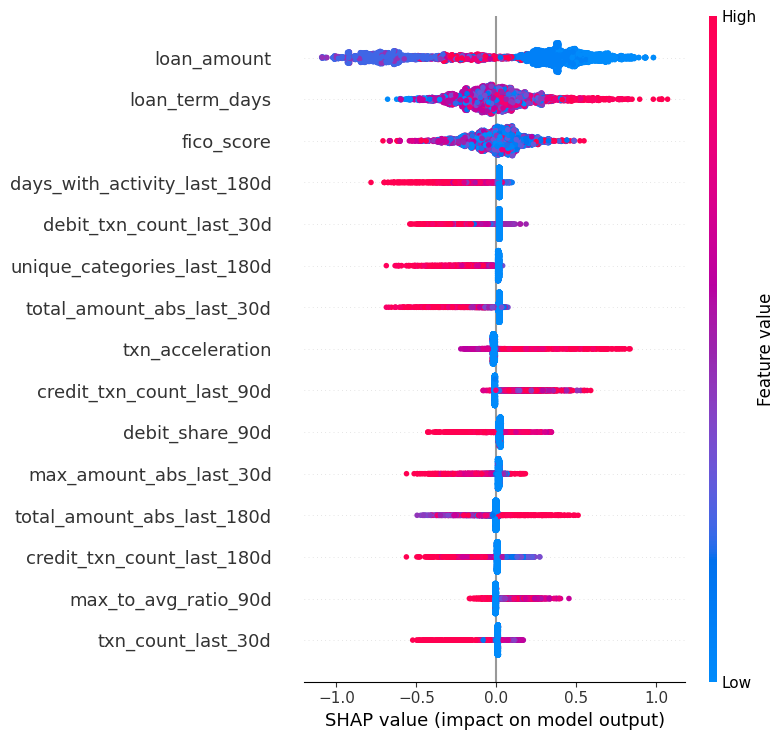

In [ ]:
# ---------------------------- Built-in Feature Importance (LightGBM) ----------------------------

# Use GAIN importance (more meaningful than split count)
fi = (
    pd.DataFrame({
        "feature": X_train.columns,
        "importance": best_model.booster_.feature_importance(
            importance_type="gain" # using gain as 'splits' can be misleading
        )
    })
    .sort_values("importance", ascending=False)
)

print("\nTop 15 features by importance (gain):")
display(fi.head(15))


# ---------------------------- SHAP (TreeExplainer) ----------------------------

import shap

# Sample rows to keep SHAP fast and readable
X_shap = X_train.sample(
    n=min(5000, len(X_train)),
    random_state=42
)

# TreeExplainer is optimized for LightGBM
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_shap)

# For binary classification:
# SHAP returns a list [class_0, class_1]
# our focus is ofcourse to explain the positive (default) class
if isinstance(shap_values, list):
    shap_values_to_plot = shap_values[1]
else:
    shap_values_to_plot = shap_values

# Global explanation: feature impact + direction
shap.summary_plot(
    shap_values_to_plot,
    X_shap,
    max_display=15
)


# Calibration

* The model ranked risk reasonably okay, so ROC and PR stayed the same after calibration.
* Calibration mainly improves probability quality, which we measure using Brier score.
* Sigmoid calibration reduced Brier from ~0.22 to ~0.165, so probabilities are much more reliable for thresholding and risk decisions.
* Isotonic was slightly worse, likely due to limited validation data, so I’d deploy sigmoid.
* When we have more data, i would want try Temparature scalling as well!

/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(



TEST (raw)
ROC-AUC : 0.6554742944031582
PR-AUC  : 0.3209565524822753
Brier   : 0.22219343447346201

TEST (sigmoid)
ROC-AUC : 0.6554742944031582
PR-AUC  : 0.3209565524822753
Brier   : 0.16487931667749411

TEST (isotonic)
ROC-AUC : 0.6544451229547487
PR-AUC  : 0.3111510613272334
Brier   : 0.16510568211434634


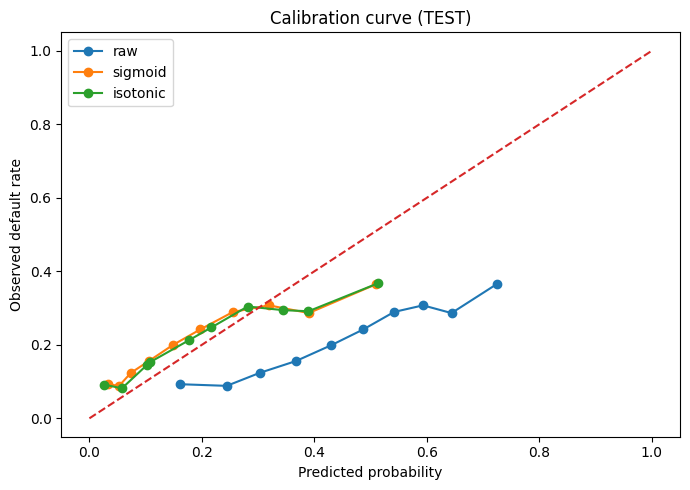

In [ ]:
# ---------------------------- Probability calibration ----------------------------
# The model ranks risk okay, but raw probabilities are not always trustworthy.
# We use VAL to recalibrate probabilities, and use TEST only for final evaluation.

import numpy as np
import matplotlib.pyplot as plt

from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss

# Use the already-trained LightGBM model
base_model = best_model


# ---------------------------- Fit calibrators on VAL ----------------------------
# cv="prefit" means:
# - base_model is already trained on TRAIN
# - we only learn a probability correction using VAL

cal_sigmoid = CalibratedClassifierCV(
    estimator=base_model,
    method="sigmoid",   # Platt scaling (simple + stable)
    cv="prefit"
)
cal_sigmoid.fit(X_val, y_val)

cal_isotonic = CalibratedClassifierCV(
    estimator=base_model,
    method="isotonic",  # more flexible, can overfit if VAL is small
    cv="prefit"
)
cal_isotonic.fit(X_val, y_val)


# ---------------------------- Predict calibrated probs on TEST ----------------------------
# TEST is never used for training or calibration

p_test_raw = base_model.predict_proba(X_test)[:, 1]
p_test_sig = cal_sigmoid.predict_proba(X_test)[:, 1]
p_test_iso = cal_isotonic.predict_proba(X_test)[:, 1]


# ---------------------------- Compare ranking + calibration quality ----------------------------
# ROC / PR-AUC check ranking
# Brier score checks probability quality (lower is better)

def print_metrics(name, y_true, p):
    print(f"\n{name}")
    print("ROC-AUC :", roc_auc_score(y_true, p))
    print("PR-AUC  :", average_precision_score(y_true, p))
    print("Brier   :", brier_score_loss(y_true, p))

print_metrics("TEST (raw)", y_test, p_test_raw)
print_metrics("TEST (sigmoid)", y_test, p_test_sig)
print_metrics("TEST (isotonic)", y_test, p_test_iso)


# ---------------------------- Calibration curve (reliability plot) ----------------------------
# Shows how close predicted probabilities are to true default rates

plt.figure(figsize=(7, 5))

for name, p in [
    ("raw", p_test_raw),
    ("sigmoid", p_test_sig),
    ("isotonic", p_test_iso),
]:
    frac_pos, mean_pred = calibration_curve(
        y_test,
        p,
        n_bins=10,
        strategy="quantile"
    )
    plt.plot(mean_pred, frac_pos, marker="o", label=name)

# calibration reference
plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("Predicted probability")
plt.ylabel("Observed default rate")
plt.title("Calibration curve (TEST)")
plt.legend()
plt.tight_layout()
plt.show()


# Data/Label/Concept: Drifts

* I track feature drift with PSI, score drift using prediction distributions, and label drift once outcomes show up. PSI is my first alert because it’s easy to explain and works well in regulated setups.
* Alerts are threshold-based: limits are learned from past data and tied to model impact, so alerts fire only when drift is likely to hurt performance, not just because noise changed.

,feature,psi
1,fico_score,0.003852
2,loan_term_days,0.001061
31,max_to_avg_ratio_90d,0.000983
0,loan_amount,0.000821
17,max_amount_abs_last_90d,0.000739
3,txn_count_last_30d,0.000711
33,category_diversity_90d,0.000682
8,max_amount_abs_last_30d,0.000630
35,loan_to_avg_txn_90d,0.000570
4,debit_txn_count_last_30d,0.000461


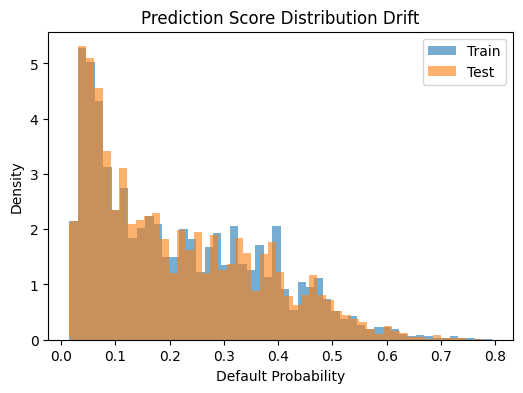

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PSI Check distribution shift between train and test col
# Bucket Level Proportion Change --> This basaically tells us “How much did the population move between bins?”

def compute_psi(train_col, test_col, bins=10):
    train_col = train_col.dropna()
    test_col  = test_col.dropna()

    quantiles = np.linspace(0, 1, bins + 1)
    breakpoints = train_col.quantile(quantiles).values
    breakpoints = np.unique(breakpoints)

    # If train feature is basically constant, PSI won't be meaningful
    if len(breakpoints) < 3:
        return 0.0

    train_counts = np.histogram(train_col, bins=breakpoints)[0] / len(train_col)
    test_counts  = np.histogram(test_col,  bins=breakpoints)[0] / len(test_col)

    train_counts = np.where(train_counts == 0, 1e-6, train_counts)
    test_counts  = np.where(test_counts  == 0, 1e-6, test_counts)

    psi = np.sum((test_counts - train_counts) * np.log(test_counts / train_counts))
    return psi


# Run PSI for each feature used by the LightGBM model
model_features = feature_cols

psi_results = []
for col in model_features:
    psi = compute_psi(X_train[col], X_test[col])
    psi_results.append({"feature": col, "psi": psi})

psi_df = pd.DataFrame(psi_results).sort_values("psi", ascending=False)
display(psi_df)


# Even if the distribution shift looks OKAY,
# Prediction shift can also indicate data drift

p_train_cal = cal_sigmoid.predict_proba(X_train)[:, 1]
p_test_cal  = cal_sigmoid.predict_proba(X_test)[:, 1]

plt.figure(figsize=(6, 4))
plt.hist(p_train_cal, bins=50, alpha=0.6, label="Train", density=True)
plt.hist(p_test_cal,  bins=50, alpha=0.6, label="Test",  density=True)
plt.legend()
plt.title("Prediction Score Distribution Drift")
plt.xlabel("Default Probability")
plt.ylabel("Density")
plt.show()
